In [44]:
import os
import time
import pickle
import pandas as pd
import numpy as np

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import random
random.seed(1333)

from dotenv import load_dotenv
load_dotenv()

True

In [45]:
cid = os.environ["SPOTIFY_CID"]
secret = os.environ["SPOTIFY_SECRET"]   
username = os.environ["SPOTIFY_USERNAME"]   
scope = 'user-library-read playlist-modify-public playlist-read-private user-read-currently-playing user-read-recently-played user-top-read'
redirect_uri = 'http://localhost:8000/connect'

token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)
sp = spotipy.Spotify(auth=token)

In [46]:
f = open("songs.pkl","rb")
songs = pickle.load(f)

songs.sample(3)

,playlist_id,track_id,track_name,track_popularity,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
146,37i9dQZF1DXa9wYJr1oMFq,0ChpoNjXfJPjMvCIN6so6J,Memory,64,Pop Punk Powerhouses,pop,pop,0.449,0.864,1.0,-3.892,1.0,0.0352,0.00002,0.000000,0.1080,0.713,167.154,226080.0,4.0
1204,37i9dQZF1DX49jUV2NfGku,3LRJbFT9rKoKv4aW7PuBJC,Longview,66,Rock Solid,rock,rock,0.381,0.732,10.0,-7.594,0.0,0.0536,0.00834,0.010100,0.0854,0.814,142.504,233240.0,4.0
1295,5BygwTQ3OrbiwVsQhXFHMz,7dQC53NiYOY9gKg3Qsu2Bs,All Out of Love,67,Classic Rock,rock,classic rock,0.512,0.262,0.0,-16.875,1.0,0.0276,0.31300,0.000006,0.4560,0.357,108.381,243000.0,4.0


In [47]:
songs.dropna(axis=0,how="any",inplace=True)

In [50]:
songs["playlist_subgenre"].value_counts()
# songs["playlist_genre"].value_counts()

gangster rap      275
classic rock      247
dance pop         224
permanent wave    214
edm               209
tropical          208
speed metal       204
reggaeton         202
hard rock         189
hip hop           177
post-teen pop     155
pop               154
latin pop         153
metal             153
big room          152
rock              150
electro house     139
rap               109
Name: playlist_subgenre, dtype: int64

## Let's start by looking into distributions
### Distributions of tempo across all genres

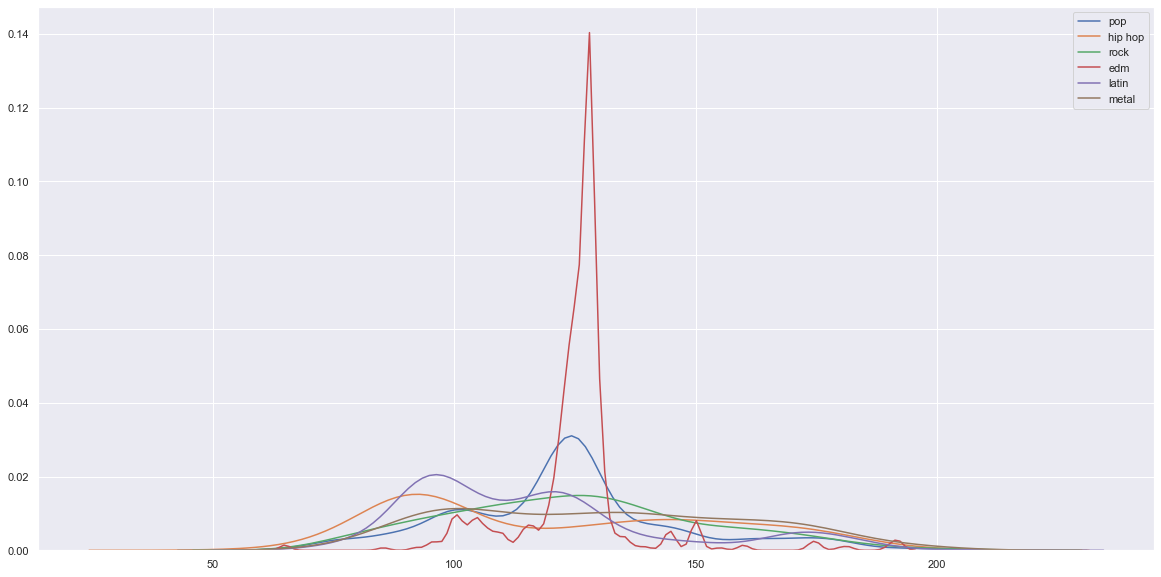

In [49]:
fig, ax = plt.subplots(1,figsize=(20,10))
for genre in songs["playlist_genre"].unique():
    sns.kdeplot(songs[songs["playlist_genre"]==genre]["tempo"],ax=ax)

plt.legend(labels=songs["playlist_genre"].unique())

### Distributions of all audio features across all genres

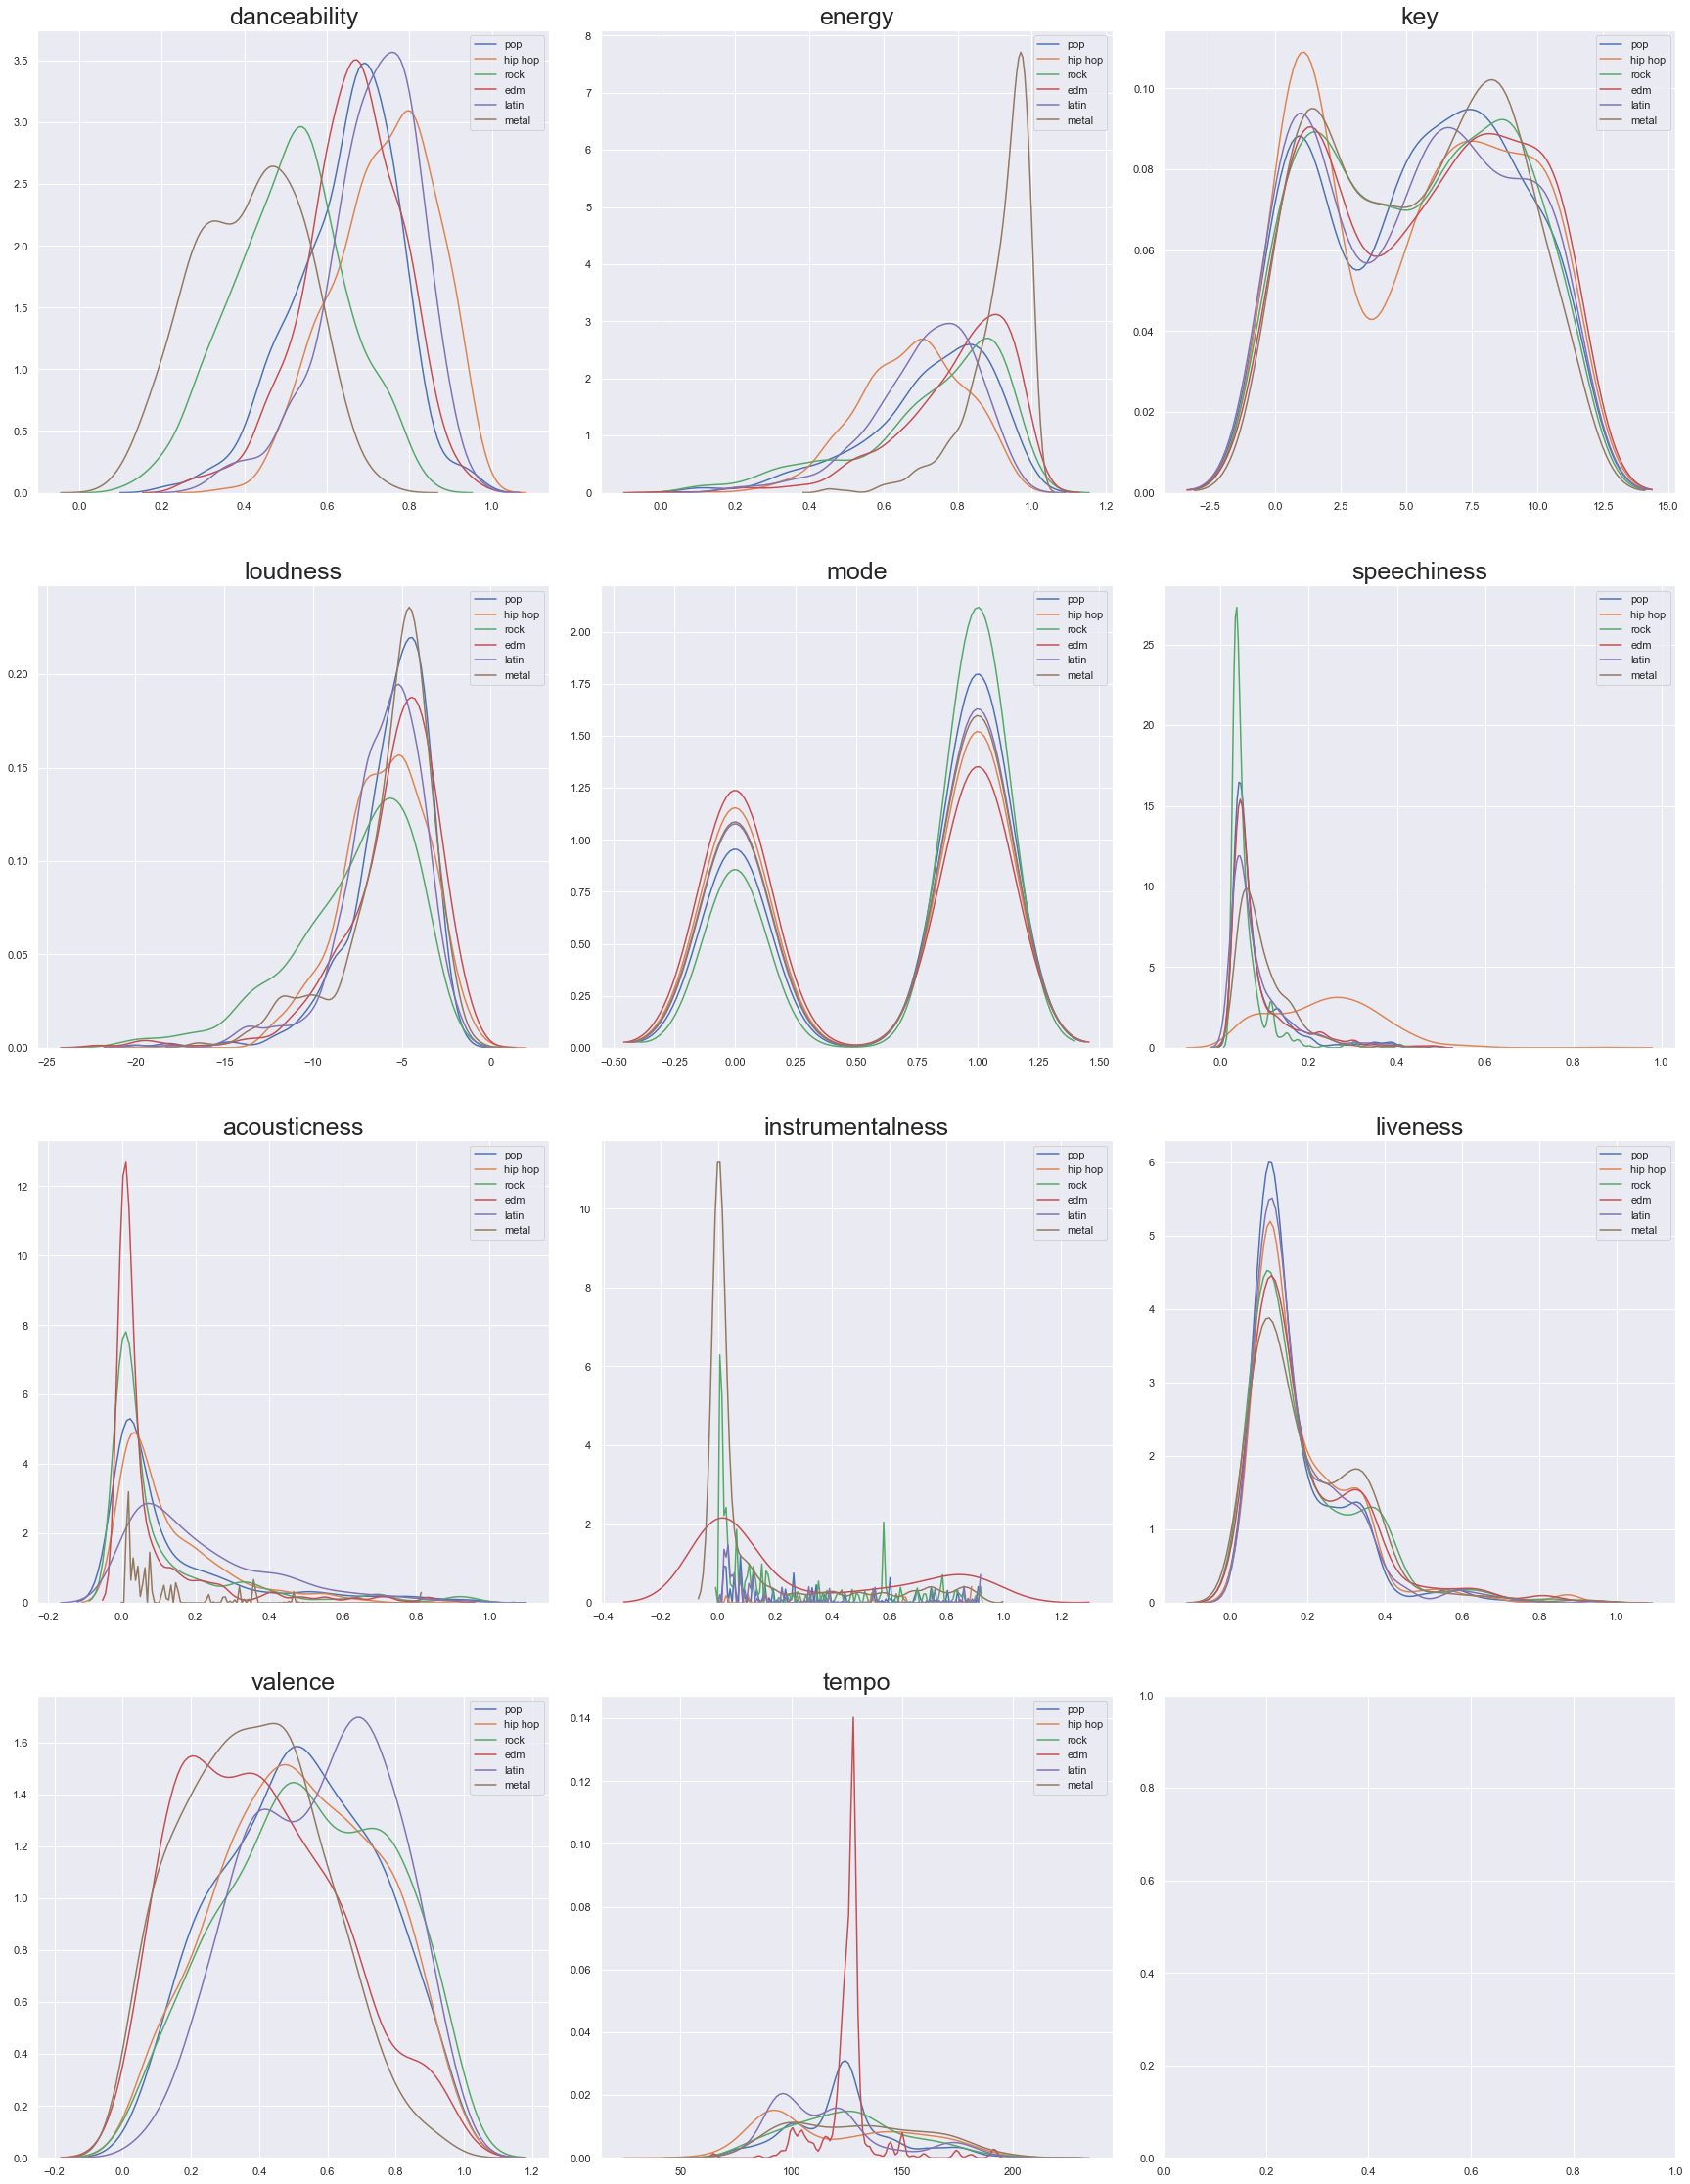

In [51]:
fig, axes = plt.subplots(4,3)
axes = axes.flatten()
fig.set_size_inches(30,40)
fig.subplots_adjust(wspace=0.1)


features_cols = songs.loc[:,"danceability":"tempo"].columns
for i,feature in enumerate(features_cols):
    for genre in songs["playlist_genre"].unique():
        sns.kdeplot(songs[songs["playlist_genre"]==genre][feature],
                    ax=axes[i],
                    label=genre).set_title(feature, fontsize=25)
        

## Heatmap of pearson correlation between features

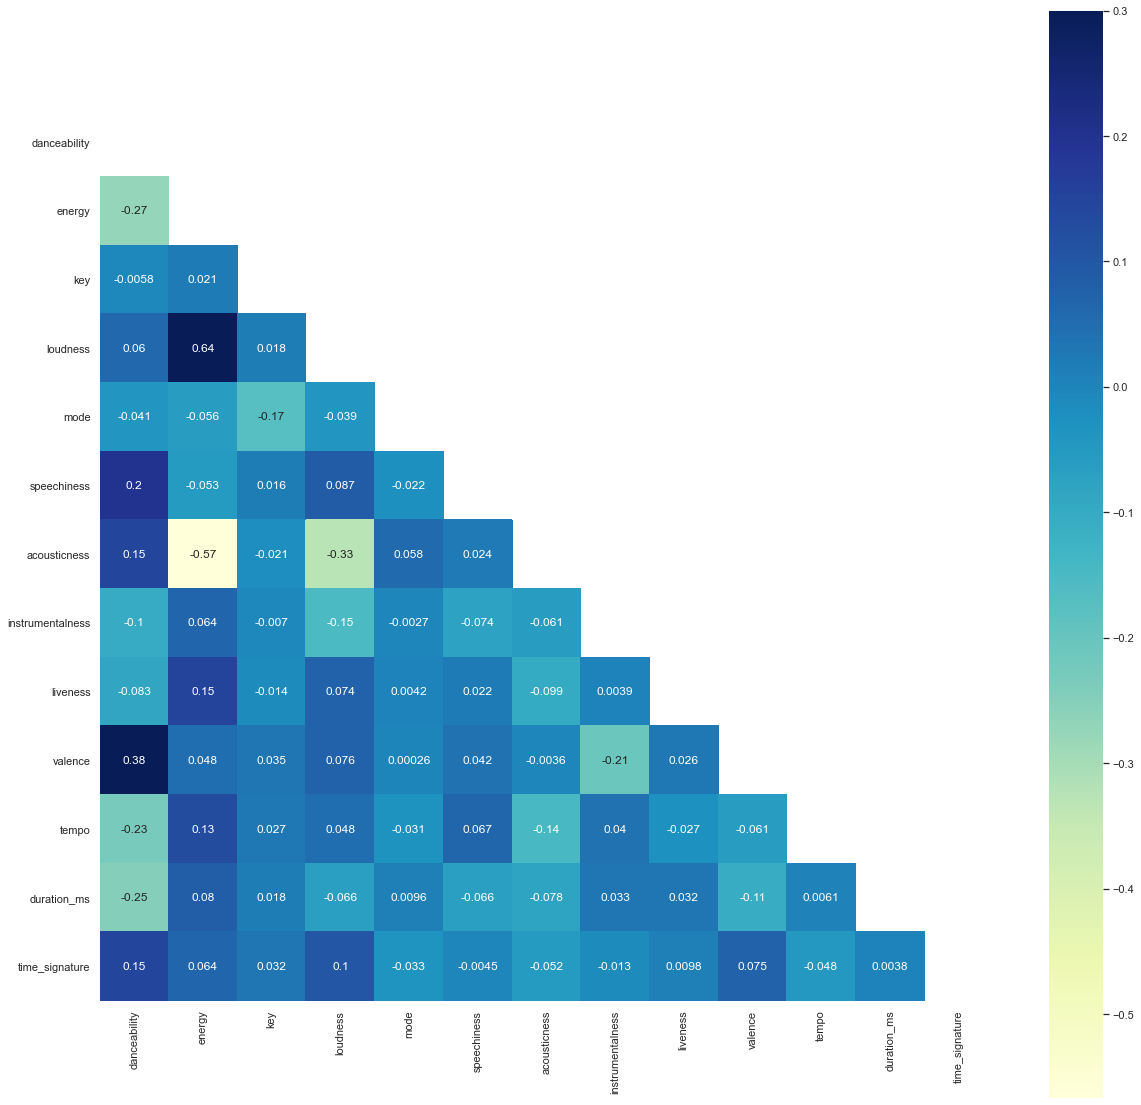

In [52]:
corr = songs.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,20))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True,cmap="YlGnBu")

## Correlations within genres

<AxesSubplot:xlabel='playlist_genre', ylabel='playlist_genre'>

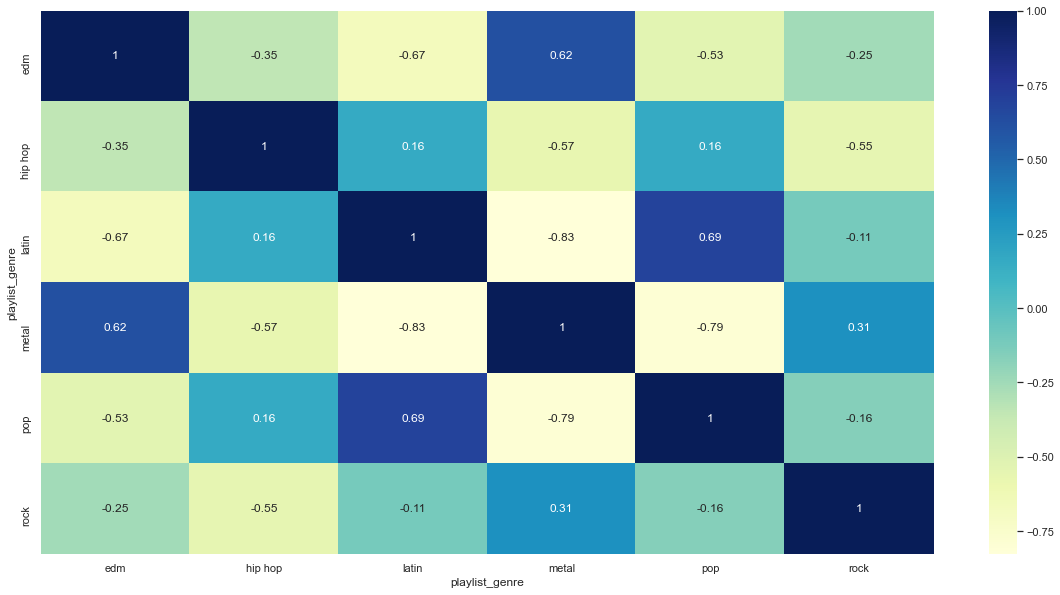

In [53]:
fig, ax = plt.subplots(1,figsize=(20,10))

from sklearn.preprocessing import StandardScaler , MinMaxScaler

corr_features = ['danceability', 'energy', 'speechiness',
       'acousticness', 'liveness', 'valence','playlist_genre']

genres_features_median = songs[corr_features].groupby(["playlist_genre"]).median()
genres_for_columns = genres_features_median.columns
scaler = StandardScaler()
genres_features_median[genres_for_columns] = scaler.fit_transform(genres_features_median)
sns.heatmap(genres_features_median.T.corr(),annot=True,cmap="YlGnBu",ax=ax)

### Getting rid of the outliers 

<AxesSubplot:xlabel='duration_ms'>

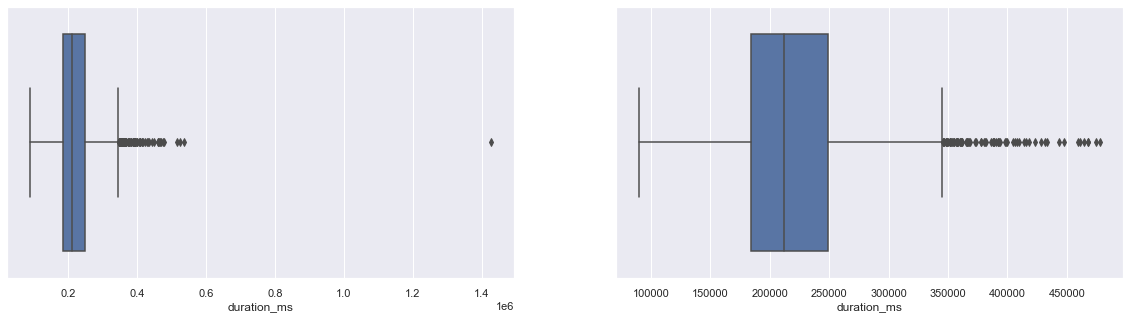

In [54]:
fig,axes = plt.subplots(1,2,figsize=(20,5))

sns.boxplot(x=songs["duration_ms"],ax=axes[0])

songs = songs[songs["duration_ms"] < 0.5*10**6]
sns.boxplot(x=songs["duration_ms"],ax=axes[1])